In [1]:
import numpy as np
import pandas as pd
import ladder
from olmo.scaling.scaling_laws.utils import validation as validation_names
from olmo.scaling.scaling_laws.utils import downstream_bpb as downstream_bpb_names
from olmo.scaling.scaling_laws.utils import downstream as downstream_names

import numpy as np
import matplotlib.pyplot as plt
from olmo.scaling.scaling_laws.utils import (
    get_coefficients_huber,
    chinchilla_flops_fit,
    grad_chinchilla_flops_fit,
    chinchilla_n_d_fit,
    grad_chinchilla_n_d_fit,
    FinalConfig,
    get_final_data_by_name,
    get_data_by_name,
)

/Users/akshitab/virtuals/olmo/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from typing import Optional

def get_gflops(run_name: str, length_in_tokens: Optional[int] = None):
    run_name, size, length = get_name_size_length(run_name)
    length_in_tokens = length_in_tokens or ladder.parse_length(length, ladder.parse_size(size))
    flops = ladder.MODEL_GFLOPS[size]
    return flops * length_in_tokens / 1e9

def get_params(run_name: str):
    run_name, size, length = get_name_size_length(run_name)
    params = ladder.MODEL_PARAMS[size]
    return params

In [3]:
from collections import defaultdict
import csv

def get_all_data_by_name(configs, keys):
    data_by_name = defaultdict(lambda: defaultdict(lambda: []))
    for name, config in configs.items():
        for path in config.paths:
            with open(path) as file_ref:
                reader = csv.DictReader(file_ref)
                rows = [row for row in reader]
                values = []
                for row in rows:
                    y = np.mean([float(row[key]) for key in keys])
                    data_by_name[name][path].append(y)
    return data_by_name

In [4]:
def size_length_from_path(path):
    #wandb/amberish-rulebased/150M-1xC.csv
    name = path.split("/")[-1].strip(".csv")
    return name.split("-")[:2]

def get_dataframe(x_dict, y_dict):
    df = pd.DataFrame()
    xs = []
    ys = []
    params = []
    sizes = []
    lengths = []
    modes = []
    runs = []
    for name, path_dict in x_dict.items():
        config = configs[name]
        for path in path_dict:
            size, length = size_length_from_path(path)
            run_name = f"{size}-{length}"
            x_data = x_dict[name][path]
            y_data = y_dict[name][path]
            xs += x_data
            ys += y_data
            params += [config.n for _ in range(len(x_data))]
            sizes += [size for _ in range(len(x_data))]
            lengths += [length for _ in range(len(x_data))]
            modes += [config.mode for _ in range(len(x_data))]
            runs += [run_name for _ in range(len(x_data))]
    df["x"] = xs
    df["y"] = ys
    df["params"] = params
    df["size"] = sizes
    df["length"] = lengths
    df["mode"] = modes
    df["run"] = runs
    return df

In [5]:
color_map = {
    "150M": "darkred",
    "300M": "darkorange",
    "530M": "gold",
    "750M": "darkgreen",
    "1B": "teal",
    #"3B":
    #"7B":
}

pd.options.mode.chained_assignment = None

def fit_and_plot_step1(df, ax, x_label, y_label, title="Fitting final score"):
    df = df.dropna()

    for label in df["size"].unique():
        adf = df[df["size"]==label]
        ax.scatter(adf["x"], adf["y"], color="white", edgecolors=adf["size"].apply(lambda x: color_map[x]), s=7.0, label=label)

    train_nds = list(df[df["mode"]=="train"][["params", "x"]].itertuples(index=False, name=None))
    train_ys = df[df["mode"]=="train"]["y"]

    # fit the parameters
    coefficients = get_coefficients_huber(
        train_nds,
        train_ys,
        chinchilla_n_d_fit,
        grad_chinchilla_n_d_fit,
        p0=[3.0, 6.0, 0.1, 0.2, 1.0],
        bounds=[(0, None), (0, None), (0, None), (0, None), (0, None)],
        disp=False,
    )
    a, b, alpha, beta, E = coefficients
    A, B = np.exp(a), np.exp(b)

    df["predicted_y"] = df.apply(lambda x: chinchilla_n_d_fit([x.params, x.x], coefficients), axis=1)
    
    eval_row = df[df["mode"]=="eval"].iloc[-1]
    x = eval_row["x"]
    y = eval_row["y"]
    y_pred = eval_row["predicted_y"]
    rel_error = (y_pred - y) / y
    
    ax.scatter(x, y, marker="x", color="blue", label=f"actual = {y:0.4f}", s=50)
    ax.scatter(x, y, marker="^", color="black", label=f"predicted = {y_pred:0.4}", s=50)
    ax.annotate(
        f"{eval_row['run']}: {rel_error * 100:+.1f}%",
        (x, y),
        textcoords="offset points",
        xytext=(30, 5),
        ha="center",
        fontsize=10,
        color="brown",
    )

    for params in df["params"].unique():
        plotted_xs = np.linspace(df[df["params"]==params]["x"].max(), df[df["params"]==params]["x"].min(), 100)
        plotted_ys = [chinchilla_n_d_fit([params, x_val], coefficients) for x_val in plotted_xs]
    
        ax.plot(
            plotted_xs,
            plotted_ys,
            color="black",
            linestyle="--",
            linewidth=0.8,
        )

    ax.text(
        x=0.25,
        y=0.50,
        s=f"L(n, d) = {A:.2f} / n^{alpha:.2f} + {B:.2f} / d^{beta:.2f} + {E:.2f}",
        fontsize=10,
        transform=plt.gca().transAxes,
    )
    
    ax.legend(loc="upper right", ncols=1)
    
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title)
    return df

In [6]:
# We only include ce loss and the 6 dolma sets, as these are the sets we can include in the paper
ce_columns = [
    'eval/c4_en-validation/CrossEntropyLoss',
    'eval/dolma_books-validation/CrossEntropyLoss',
    'eval/dolma_common-crawl-validation/CrossEntropyLoss',
    'eval/dolma_pes2o-validation/CrossEntropyLoss',
    'eval/dolma_reddit-validation/CrossEntropyLoss',
    'eval/dolma_stack-validation/CrossEntropyLoss',
    'eval/dolma_wiki-validation/CrossEntropyLoss',
]

mmlu_names = ["mmlu_stem", "mmlu_humanities", "mmlu_social_sciences", "mmlu_other"]

tasks = {
    "HellaSwag-0shot": {
        "bpb": ["eval/downstream_bpb/hellaswag_rc_0shot_bpb_bpb"],
        "score": ["eval/downstream/hellaswag_rc_0shot_len_norm"],
    },
    "MMLU-Var": {
        "bpb": [f"eval/downstream_bpb/{n}_var_bpb_bpb" for n in mmlu_names],
        "score": [f"eval/downstream/{n}_var_len_norm" for n in mmlu_names],
        "x_label": "mmlu_var_bpb",
        "y_label": "mmlu_var_score",
    },
    "HellaSwag-5shot": {
        "bpb": ["eval/downstream_bpb/hellaswag_rc_5shot_bpb_bpb"],
        "score": ["eval/downstream/hellaswag_rc_5shot_len_norm"],
    },
    "ARC-Easy-5shot": {
        "bpb": ["eval/downstream_bpb/arc_easy_rc_5shot_bpb_bpb"],
        "score": ["eval/downstream/arc_easy_rc_5shot_acc"],
    },
    "ARC-Challenge-5shot": {
        "bpb": ["eval/downstream_bpb/arc_challenge_rc_5shot_bpb_bpb"],
        "score": ["eval/downstream/arc_challenge_rc_5shot_len_norm"],
    },
    "PiQA-5shot": {
        "bpb": ["eval/downstream_bpb/piqa_rc_5shot_bpb_bpb"],
        "score": ["eval/downstream/piqa_rc_5shot_len_norm"],
    },
    "Winogrande-5shot": {
        "bpb": ["eval/downstream_bpb/winogrande_rc_5shot_bpb_bpb"],
        "score": ["eval/downstream/winogrande_rc_5shot_acc"],
    },
    "OpenbookQA-5shot": {
        "bpb": ["eval/downstream_bpb/openbookqa_rc_5shot_bpb_bpb"],
        "score": ["eval/downstream/openbookqa_rc_5shot_len_norm"],
    },
    "BoolQ-5shot": {
        "bpb": ["eval/downstream_bpb/boolq_rc_5shot_bpb_bpb"],
        "score": ["eval/downstream/boolq_rc_5shot_acc"],
    },
    "SciQ-0shot": {
        "bpb": ["eval/downstream_bpb/sciq_rc_0shot_bpb_bpb"],
        "score": ["eval/downstream/sciq_rc_0shot_acc"],
    },
    "Copa-0shot": {
        "bpb": ["eval/downstream_bpb/copa_rc_0shot_bpb_bpb"],
        "score": ["eval/downstream/copa_rc_0shot_acc"],
    },
    "CSQA-5shot": {
        "bpb": ["eval/downstream_bpb/csqa_rc_5shot_bpb_bpb"],
        "score": ["eval/downstream/csqa_rc_5shot_len_norm"],
    },
    "SocialIQA-5shot": {
        "bpb": ["eval/downstream_bpb/socialiqa_rc_5shot_bpb_bpb"],
        "score": ["eval/downstream/socialiqa_rc_5shot_len_norm"],
    }
}

In [7]:
# One-off hackery to use the _newline metrics

from olmo.scaling.scaling_laws.utils import downstream_newline_bpb, downstream_newline

df = pd.read_csv("wandb/amberish1-newline/1B-3T.csv")

mapper = {}
for key in downstream_newline:
    if "hellaswag" in key or "winogrande" in key:
        continue
    new_key = f"eval/downstream/{key}"
    old_key = new_key.replace("_newline", "")
    assert new_key in df.columns, new_key
    assert old_key in df.columns, old_key
    mapper[new_key] = old_key

for key in downstream_newline_bpb:
    if "hellaswag" in key or "winogrande" in key:
        continue
    new_key = f"eval/downstream_bpb/{key}_bpb"
    old_key = new_key.replace("_newline", "")
    assert new_key in df.columns, new_key
    assert old_key in df.columns, old_key
    mapper[new_key] = old_key

df.drop(list(mapper.values()), axis=1).rename(columns=mapper).to_csv("wandb/amberish1-newline/1B-3T-renamed.csv")

In [8]:
configs = {
    "150m": {
        "paths": [
            "wandb/amberish-rulebased/150M-1xC.csv",
            "wandb/amberish-rulebased/150M-2xC.csv",
            "wandb/amberish-rulebased/150M-5xC.csv",
            "wandb/amberish-rulebased/150M-10xC.csv"
        ],
        "mode": "train",
        "n": 151898880,
        "label": "150m",
        "color": "darkred"
    },
    "300m": {
        "paths": [
            "wandb/amberish-rulebased/300M-1xC.csv",
            "wandb/amberish-rulebased/300M-2xC.csv",
            "wandb/amberish-rulebased/300M-5xC.csv",
            "wandb/amberish-rulebased/300M-10xC.csv"
        ],
        "mode": "train",
        "n": 319980544,
        "label": "300m",
        "color": "darkorange"
    },
    "530m": {
        "paths": [
            "wandb/amberish-rulebased/530M-1xC.csv",
            "wandb/amberish-rulebased/530M-2xC.csv",
            "wandb/amberish-rulebased/530M-5xC.csv",
            "wandb/amberish-rulebased/530M-10xC.csv"
        ],
        "mode": "train",
        "n": 530074944,
        "label": "530m",
        "color": "gold"
    },
    "700m": {
        "paths": [
            "wandb/amberish-rulebased/750M-1xC.csv",
            "wandb/amberish-rulebased/750M-2xC.csv",
            "wandb/amberish-rulebased/750M-5xC.csv",
            "wandb/amberish-rulebased/750M-10xC.csv"
        ],
        "mode": "train",
        "n": 681297408,
        "label": "750m",
        "color": "darkgreen"
    },
    "1b": {
        "paths": [
            "wandb/amberish-rulebased/1B-1xC.csv",
            "wandb/amberish-rulebased/1B-2xC.csv",
            "wandb/amberish-rulebased/1B-5xC.csv",
            "wandb/amberish-rulebased/1B-10xC.csv"
        ],
        "mode": "train",
        "n": 1176832000,
        "label": "1b",
        "color": "teal"
    },
    "1b-final": {
        "paths": [
            #"wandb/amberish-rulebased/1B-10xC.csv"
            "wandb/amberish1-newline/1B-3T-renamed.csv"
        ],
        "mode": "eval",
        "n": 1176832000,
        "label": "1b",
        "color": "teal"
    }
}

configs = {name: FinalConfig(**config) for name, config in configs.items()}

coeffs: [2.87581215 4.68965479 0.2196752  0.28977168 0.53110508]
coeffs: [2.17932399 4.98456266 0.10252623 0.26117113 0.        ]
coeffs: [2.30545054 5.01062863 0.17925253 0.30682705 0.46327775]
coeffs: [ 3.9725289  10.05706052  0.21405529  0.49200775  0.        ]
coeffs: [7.49284759 2.6689688  0.45168685 0.14362579 0.36573595]
coeffs: [4.26531326 5.47720591 0.29763913 0.31616094 0.79694167]
coeffs: [1.07491035 3.51530031 0.10299542 0.22122259 0.86842857]
coeffs: [7.11348163 3.56348298 0.4375386  0.20407148 1.10709001]
coeffs: [24.83208494  1.39725273  1.4519645   0.18589129  0.35382925]
coeffs: [6.2316817  6.75003907 0.3846524  0.29382903 0.        ]
coeffs: [4.97958366 5.01776285 0.32867292 0.2983824  0.67045581]
coeffs: [3.31060199 5.01087341 0.17432894 0.24967954 0.00593208]
coeffs: [1.87722505 2.80847756 0.10029269 0.17060324 0.        ]


/var/folders/2h/2k7br48j493_xlq7pgyby7xw0000gp/T/ipykernel_68431/2022610657.py:19: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  fig.tight_layout()


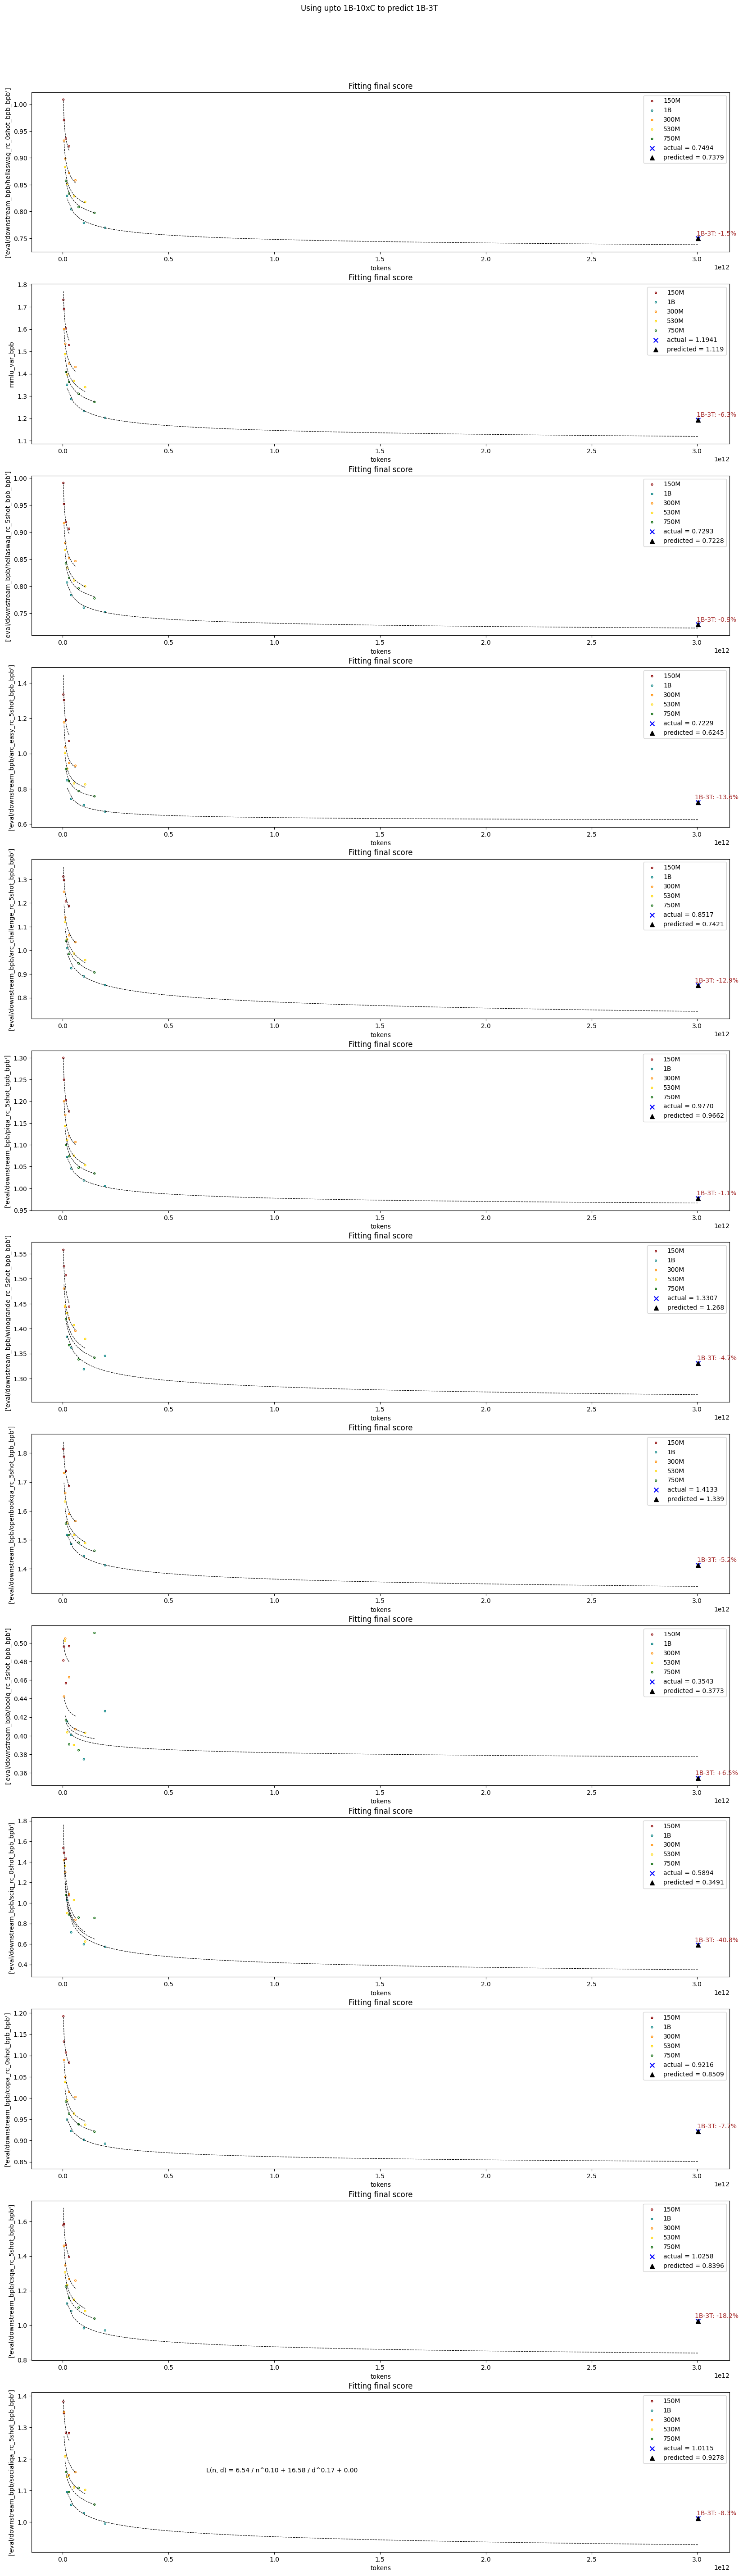

In [9]:
rows = len(tasks.keys())
fig, axes = plt.subplots(rows, 1, figsize=(20, 5 * rows))

for i, (task_name, task) in enumerate(tasks.items()):

    tokens = get_all_data_by_name(configs, ["throughput/total_tokens"])
    bpb_loss = get_all_data_by_name(configs, task['bpb'])

    df = get_dataframe(tokens, bpb_loss)
    fdf = df.groupby('run').apply(lambda rows: rows.iloc[-1], include_groups=False).reset_index()
    fdf = fit_and_plot_step1(
        fdf,
        axes[i],
        x_label="tokens",
        y_label=str(task.get("x_label", task['bpb'])),
    )

fig.suptitle('Using upto 1B-10xC to predict 1B-3T', fontsize=12)
fig.tight_layout()
fig.subplots_adjust(top=0.95)
#plt.savefig(f"{FIGURES}/downstream-upto-1B-5xC.png", dpi=300)